# A/B Test로 고객 retention을 높이기
모바일 게임의 고객 로그 데이터를 분석해서 고객 유지율을 높이기

### 데이터 설명
데이터는 아래의 케글에서 확인 가능
(https://www.kaggle.com/yufengsui/mobile-games-ab-testing)

  * **userid** - 개별 유저들을 구분하는 식별 번호  
  * **version** - 유저들이 실험군 대조군 중 어디에 속했는지 알 수 있다. (gate_30, gate_40) 
  * **sum_gamerounds** - 첫 설치 후 14일 간 유저가 플레이한 라운드의 수  
  * **retention_1** - 유저가 설치 후 1일 이내에 다시 돌아왔는지 여부 
  * **retention_7** - 유저가 설치 후 7일 이내에 다시 돌아왔는지 여부  
  * 게임 플레이 영상 참고 (https://www.youtube.com/watch?v=xt_5OtfXl7o)

# 문제 정의 
  * Cookie Cats 게임에서는 특정 스테이지가 되면 스테이지가 Lock 된다.
  * Area Locked일 경우 Keys를 구하기 위해 특정 게임을 해서 key 3개를 구하거나, 페이스북 친구를 초대해 key를 요청하거나, 유료아이템을 구매하여 바로 열 수 있다. (즉 게임진행을 위한 일종의 장벽 = gate를 설정)
  
  ![Area Locked](https://s3.amazonaws.com/assets.datacamp.com/production/project_184/img/cc_gates.png)
  
  
  * 이때 유저에게 특정 스테이지를 몇번째에 제시할지에 대해 판단을 해야 한다.
  
  
  * 이 경우 보통 의견이 2가지로 나뉜다. 
  
  
    첫째, 유저가 게임에 흥미를 보이는 초반에 특정 스테이지를 제시해서 retention을 높여야 한다.
    
    둘째, 초반부터 장벽을 두면 유저가 게임에 거부감을 느낄 수 있으므로, 게임을 충분히 즐겨서 빠져들게 만든뒤 gate를 제시해서 retention을 높여야 한다.
  
  
  * 이 두가지 의견중에 어떤 것이 더 적합한 판단인지 해당 유저들의 데이터를 분석한뒤 A/B test를 통해 판단 기준을 만들어야 한다.
  
  
  * 실제 마케팅을 하는 입장에서는 단순히 단기적인 retention을 높이는 것만이 능사가 아닌 경우도 있다. 단순히 retention뿐만이 아니라 장기적으로 고객과의 관계 유지를 위한 결정을 내려야 할때도 있을 것이다. 하지만 이 분석에서는 retention 데이터만을 가진 테이블이기 때문에 retention을 높이는 것에 중점을 두고 분석을 진행할 것이다.

# 데이터 탐색

In [164]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 컬럼 전체 확인 가능하도록 출력 범위 설정
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')


data = pd.read_csv("cookie_cats.csv")

print(data.shape)
data.tail()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [165]:
# 결측값이 있는지 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


shape와 동일한 90189개의 데이터를 모두 갖고 있다. (결측치 없음)

In [166]:
# AB 테스트로 사용된 버전별 유저의 수 확인
# version - 유저들이 실험군 대조군 중 어디에 속했는지 알 수 있다. (gate_30, gate_40)

data.groupby("version").count() #version별로 grouping해서 각 컬럼의 값을 count

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


유저가 게임을 설치하면 gate_30 또는 gate_40 그룹으로 나뉘게 되었는데, 각 그룹별 유저는 거의 유사한 숫자로 배정되었다. 

<AxesSubplot:ylabel='sum_gamerounds'>

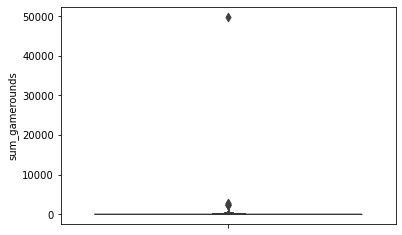

In [167]:
# big dataset 이기 때문에 4분위로 값을 표현하는 boxplot보다는 50%부터 시작되는 boxenplot(=letter-value plots) 이 더 적합하다 판단.
# boxenplot을 그려 이상치가 있는지 확인

sns.boxenplot(data=data, y="sum_gamerounds")

* boxplot자체가 거의 보이지 않을정도로 상당히 큰 이상치가 있다.
* 첫 14일 동안 50,000회 가까이 게임을 한 사람들이 분명히 있지만 일반적인 사용행태라고 하기는 어렵다. 
* 엄청나게 skewed(비대칭적인) 데이터 분포형태

In [168]:
# 이상치로 나타나는 50000회 가까이 게임을한 유저가 몇명인지 확인

data[data["sum_gamerounds"] > 45000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [169]:
# 9만개의 데이터중 이상치가 1개뿐이므로 원활한 데이터 분석을 위해 해당 데이터 drop
# 원본데이터를 재활용할 가능성도 있으므로 data2에 할당하여 추후 분석 진행

data2 = data[data["sum_gamerounds"] < 45000 ]
print(data2.shape)
data2.tail()

(90188, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [170]:
# percentile을 확인 => 분위수 확인 : 유저들이 가입후 14일간 얼마나 많이 플레이 했는지 대략적으로 파악 가능

data2["sum_gamerounds"].describe()

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

* 전체 유저 중 (진행한 game round가 높은)상위 50%의 유저들은 첫 14일 동안 게임을 16회 플레이 했음을 알 수 있다.

<AxesSubplot:ylabel='sum_gamerounds'>

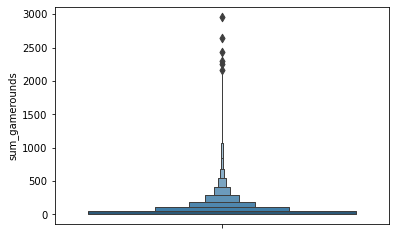

In [171]:
# 새롭게 만든 data2에서도 이상치가 나타나는지 확인

sns.boxenplot(data=data2, y="sum_gamerounds")

# 데이터 분석 (A / B 집단별 비교)

In [172]:
# 각 게임실행횟수 별 유저의 수를 카운트 by group
# 각 게임 실행횟수별로 몇명의 유저가 있는지 확인

user_data = data2.groupby("sum_gamerounds")["userid"].count()

print(len(user_data)) #게임횟수 실행한 경우가 총 941 가지

user_data

941


sum_gamerounds
0       3994
1       5538
2       4606
3       3958
4       3629
        ... 
2251       1
2294       1
2438       1
2640       1
2961       1
Name: userid, Length: 941, dtype: int64

## Round별 플레이 횟수 추이 (line)

Text(0, 0.5, 'Number of Players')

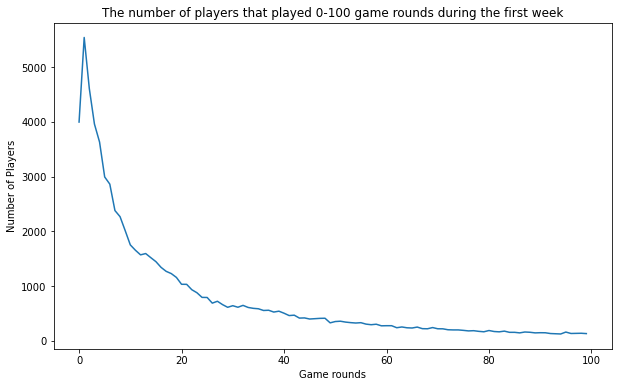

In [173]:
%matplotlib inline

ax = user_data[:100].plot(figsize=(10,6))
ax.set_title("The number of players that played 0-100 game rounds during the first week")
ax.set_xlabel('Game rounds')
ax.set_ylabel("Number of Players")

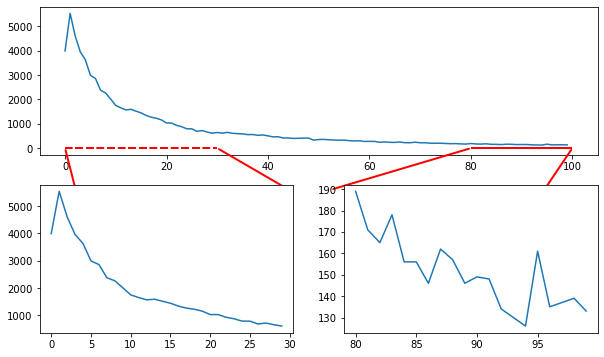

In [174]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def zoomingBox(ax1, roi, ax2, color='red', linewidth=2):
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2],**dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)]) ))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)]))




plt.figure(figsize=(10,6))
ax1 = plt.subplot(2,1,1)
plt.plot(user_data[:100])

ax2 = plt.subplot(2,2,3)
plt.plot(user_data[:30])

ax3 = plt.subplot(2,2,4)
plt.plot(user_data[80:100])

zoomingBox(ax1, [0,30,-1.1,1.1], ax2)
zoomingBox(ax1, [80,100,-1.1,1.1], ax3)

plt.show()

* 게임을 설치하고 1번도 플레이 하지 않은 유저가 4000여명으로 매우 많다는 것을 확인할 수 있다. (retention이 되지 않은 유저)

## 플레이 횟수 데이터의 분포 및 횟수 별 분포 확인(distplot)

<AxesSubplot:xlabel='sum_gamerounds', ylabel='Density'>

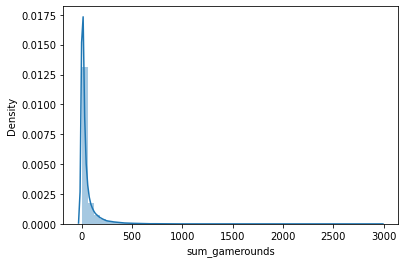

In [175]:
sns.distplot(data2["sum_gamerounds"])

* 0회 이상 플레이한 유저들이 상당 수 있으며 그 빈도도 500회 이하 부분에는 몰려있다. 
* 이로 보아 몇몇 유저들은 설치 첫주에 게임을 충분히 실행하면서 게임에 몰입하고 있다는 것을 알 수 있다.


* 비디오 게임산업에서 **1-day retention**은 게임이 얼마나 재미있고 중독적인지 평가하는 주요 메트릭이다.
* **1-day retention**이 높을 경우 손쉽게 가입자 기반을 늘려갈 수 있다. 

In [176]:
# 1-day retention의 평균을 확인. 

round(data2["retention_1"].mean(),4)

0.4452

* 절반에 못미치는 사용자들이 설치 다음날 다시 게임을 했다는 것을 알 수 있다. 

In [177]:
# 그룹별 1-day retention의 평균을 확인. 

round(data2.groupby("version")["retention_1"].mean(),4)

version
gate_30    0.4482
gate_40    0.4423
Name: retention_1, dtype: float64

* 단순히 그룹간 평균을 비교해봐서는 gate_40(44.2%)보다 gate_30(44.8%)인 경우의 플레이 횟수가 더 많다. 
* 작은 차이이지만 이 작은 차이가 retention, 그리고 장기적으로 본다면 수익에 영향을 미칠 수 도 있다.

## retention7일때는 어떨까?(추가 검증)

In [178]:
# 7-day retention의 평균을 확인

round(data2["retention_7"].mean(), 4)

0.1861

In [179]:
# 그룹별 7-day retention의 평균을 확인

round(data2.groupby("version")["retention_7"].mean(),4)

version
gate_30    0.1902
gate_40    0.1820
Name: retention_7, dtype: float64

* 단순히 그룹간 평균을 비교해봐서는 gate_40(18.2%) 보다 gate_30(19.0%)인 경우에 생존률이 더 높다.  
* 작은 차이이지만 이 작은 차이가 retention, 그리고 장기적으로 본다면 수익에 영향을 미칠 수 도 있다.

* retention1 보다 retention7일때의 차이가 더 크다. 하지만 이 2개의 단순 값 비교는 수치의 차이도 적은편이고, 이 데이터를 무조건적으로 믿고 retention 기준을 잡기는 다소 애매하다. 추가적인 검증을 해보자

## Bootstrapping (추가검증 2) - 정말로 두 집단간의 차이가 있는게 맞을까?

* 하나의 데이터가 모든 실제 데이터를 반영하지 못하기 때문에 일종의 Over sampling을 하는 과정

* 이 과정을 통해 두 그룹간의 차이가 유의미한지 확인할 것이다.


In [180]:
#for문의 수행시간 확인 위해 로드
from tqdm import tqdm

# 각각의 AB그룹에 대해 bootstrap된 means 값의 리스트 생성
boot_1d = []
for i in tqdm(range(1000)):
    # frac : 전체 row에서 몇%의 데이터를 return할 것인지
    # replace : 중복샘플 추출을 허용할 것인지
    boot_mean = data2.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.27it/s]


<AxesSubplot:ylabel='Density'>

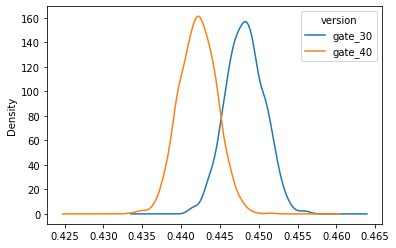

In [181]:
# list를 data2Frame으로 변환 
boot_1d = pd.DataFrame(boot_1d)

# 부트스트랩 분포에 대한 Kernel Density Estimate plot 시각화
boot_1d.plot(kind='density')

* 위의 두 분포는 AB 두 그룹에 대해 1 day retention이 가질 수 있는 부트 스트랩 불확실성을 표현한 것.
* 두 그룹간에 큰 차이가 있는 것은 아니지만 분명이 차이가 있다는 것은 검증되었다.  


 

두 그룹간의 차이를 자세히 살펴보기 위해 % 차이를 시각화

gate(장벽)가 레벨30에 있을 때 1-day retention이 gate(장벽)가 레벨40에 있을 때 보다 더 클 확률: 95.39999999999999 %


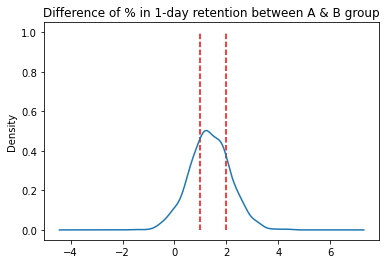

In [182]:
# 두 AB 그룹간의 % 차이 평균 컬럼을 추가한다.
boot_1d['difference'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# bootstrap % 차이를 시각화 한다. 
ax = boot_1d['difference'].plot(kind='density') #AB 두그룹간에 평균 차이 정도가 빈도별로 얼마나 분포하는지 
ax.set_title('Difference of % in 1-day retention between A & B group')

# gate가 레벨30에 있을 때 1-day retention이 7-day retention 보다 더 클 확률을 계산 
print('gate(장벽)가 레벨30에 있을 때 1-day retention이 gate(장벽)가 레벨40에 있을 때 보다 더 클 확률:',(boot_1d['difference'] > 0).mean()*100,'%')

# 수치가 높은 부분 강조
ax.vlines([1, 2], 0, 1, linestyles='dashed', colors='red')

* 위 도표에서 가장 가능성이 높은 % 차이는 약 1%-2%이며 분포의 95%는 0% 이상이며 레벨 30의 gate를 선호한다고 할 수 있다.


* Bootstrap 분석에 따르면 gate가 레벨 30에있을 때 1-day retention 이 더 높을 가능성이 높다.


* 그러나 위에서 살펴봤듯이, 대부분의 유저들은 하루정도만 플레이했다. 그러므로 다수의 플레이어들이 레벨 30까지 도달하지 못했을 가능성을 염두해야 한다.


* 즉, 대다수의 유저들은 gate가 30에 있는지 여부에 따라 retention이 영향받지 않았을 가능성이 크다.


* **그러므로 7-day retention도 확인을 해야 한다.** 왜냐하면 일주일 동안 플레이 한 후에는 플레이어가 레벨 30과 40에 도달할 가능성이 늘어나기 때문이다.

In [183]:
data2.groupby('version')['retention_7'].sum() / data2.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

* 1일 retention과 마찬가지로, gate가 30 레벨(19.0 %)에 있는 경우보다 gate 레벨이 40(18.2 %)인 경우 7일 retention이 낮다.
* 이 차이는 1 일 retention보다 차이가 더 큰데, 아마도 더 많은 플레이어가 첫 번째 gate를 열어볼 시간이 있었기 때문일 것 
* 전체 7일 retention은 전체 1일 retention보다 낮다. 설치 후 하루보다 설치 후 일주일에 게임을하는 사람이 더 적기 때문 
* 이전과 마찬가지로 부트 스트랩 분석을 사용하여 AB 그룹간에 차이가 있는지 확인해봅시다.

In [184]:
# 각각의 AB그룹에 대해 bootstrapp된 means 값의 리스트를 만듭니다.
boot_7d = []
for i in tqdm(range(500)):
    boot_mean = data2.sample(frac=1,replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 73.09it/s]


gate(장벽)가 레벨30에 있을 때 7-day retention이 gate(장벽)가 레벨40에 있을 때 보다 더 클 확률: 100.0 %


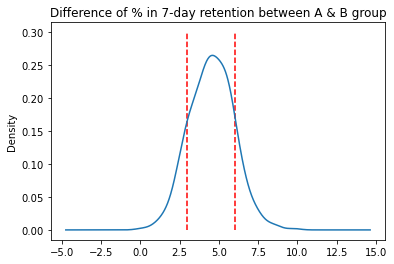

In [185]:
 
# list를 data2Frame으로 변환한다. 
boot_7d = pd.DataFrame(boot_7d)

# 두 AB 그룹간의 % 차이 평균 컬럼을 추가한다.
boot_7d['difference'] = (boot_7d.gate_30 - boot_7d.gate_40)/boot_7d.gate_40*100

# bootstrap % 차이를 시각화 한다.
ax = boot_7d['difference'].plot(kind='density')
ax.set_title('Difference of % in 7-day retention between A & B group')

# gate가 레벨30에 있을 때 7-day retention이 더 클 확률을 계산한다. 
print('gate(장벽)가 레벨30에 있을 때 7-day retention이 gate(장벽)가 레벨40에 있을 때 보다 더 클 확률:',(boot_7d['difference'] > 0).mean()*100,'%')

# 수치가 높은 부분 강조
ax.vlines([3, 6], 0, 0.3, linestyles='dashed', colors='red')

* 부트 스트랩 결과는 gate가 레벨 40에있을 때보 다 레벨 30에있을 때 7일 retention이 더 높다는 강력한 증거가 된다.
  (gate(장벽)가 레벨30에 있을 때 7-day retention이 더 클 확률이 100%이므로)


* 즉, **retention을 늘리기 위해서 gate를 레벨 30에서 레벨 40으로 이동해서는 안된다**

# 통계적 기법으로 검증

## T-test

gate가 30인 데이터를 분석하기 위해 별도 테이블 생성

In [195]:
data_gate_30 = data2[data2["version"] == "gate_30"] 

print(data_gate_30.shape)

data_gate_30.tail()

(44699, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90179,9998576,gate_30,14,True,False
90180,9998623,gate_30,7,False,False
90182,9999178,gate_30,21,True,False
90183,9999349,gate_30,10,False,False
90186,9999710,gate_30,28,True,False


In [196]:
data_gate_40 = data2[data2["version"] == "gate_40"] 

print(data_gate_40.shape)

data_gate_40.tail()

(45489, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90181,9998733,gate_40,10,True,False
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


T-test 를 하는이유?

- 위의 분석에서 A, B 두 그룹이 다르다고 결과가 나왔기 때문에 실제로 통계적으로도 두 그룹이 다른 데이터 인지 검증하기 위함

In [204]:
from scipy import stats

#독립표본 T-검정 (2 Sample T-Test)

# 1 day retention 데이터로 T test

t_TestResult = stats.ttest_ind(data_gate_30['retention_1'], data_gate_40['retention_1'])

t_TestResultDiffVar = stats.ttest_ind(data_gate_30['retention_1'], data_gate_40['retention_1'], equal_var=False)

t_TestResult 

Ttest_indResult(statistic=1.7871153372992439, pvalue=0.07392220630182521)

In [199]:
t_TestResult2 = stats.ttest_ind(data_gate_30['retention_7'], data_gate_40['retention_7'])

t_TestResultDiffVar2 = stats.ttest_ind(data_gate_30['retention_7'], data_gate_40['retention_7'], equal_var=False)

t_TestResult2

Ttest_indResult(statistic=3.1575495965685936, pvalue=0.0015915357297854773)

##### T Score

* Ttest_indResult의 statistics 부분이 t-score


- t-score가 크면 **[두 그룹이 다르다]**는 것을 의미


- t-score가 작으면 **[두 그룹이 비슷하다]**는 것을 의미

##### P-values
- p-value는 5%수준에서 0.05  


- p-values는 **작을 수록 좋다.** 


- p-value가 유의미한 범주안에 있다면, 이는 데이터가 우연히 발생한 것이 아니라는 것을 의미한다. 


- e.g) p-value가 0.01 이라는 것은 결과가 우연히 나올 확률이 1%에 불과하다는 것


- 통계학적으로 p-value가 0.05 (5%) 수준이면 신뢰할 수 있는 결과로 판단하고, '통계적으로 유의하다' 고 표현 한다.



[T-test 참고링크](https://www.statisticshowto.data2sciencecentral.com/probability-and-statistics/t-test/)

## T-test 결과 해석

**[retention_1]**

* retention_1 데이터로 T-test를 한 결과 p-value가 0.073 (>0.05) 로 유의하지 않다.


* 즉, 위의 분석에서 retention1에서 gate30일때의 결과와 gate40일때의 결과가 차이가 난다고 했을때, 이 차이가 A/B test에 의해 발생한 것이라 볼 수는 없다는 의미이다.

**[retention_7]**


* retention_7 데이터로 T-test를 한 결과 p-value가 0.001 (<0.05) 로 유의하다.


* 즉, retention_7에서 발생한 gate30 집단과 gate40집단의 A/B test를 통해 발견된 차이는 우연히 발생한 일이 아니다. (확률적으로 일어난 것이다.)  => 두 그룹간에 차이가 있는 것이 맞다.

**[결론]**

**retention_7 을 기준으로 볼때 gate는 30 levl에 있는 것 보다는 40 level에 있는 것이 고객 retnetion을 위해 더 좋은 선택이 될 것이다.**


하지만 위에서 진행한 T-test는 고객 retention이 발생했다 =1, 발생하지 않았다 = 0 이라는 가정하에 분석을 한 것이다.

실제 분석에 사용한 데이터는 1,0의 이진분류가 아닌 '범주형' 데이터 이다.  그러므로 통계적으로 적합한 분석방법은 되지 못한다.




**[ 마케팅에서 A/B test에 대한 T-검정을 사용할 수 있는 예시 ]**

어떤 회사가 연예인 모델 A를 새로 선발하여 광고를 게시하였을때, **A가 모델로 선발되기 이전에 해당 기업의 performance**와 **A가 모델로 선발된 이후의 performance**를 비교하고자 할때

## chi-square

* 카이제곱검정은 어떤 범주형 확률변수  𝑋 가 다른 범주형 확률변수  𝑌 와 독립인지 상관관계를 가지는가를 검증하는데도 사용된다.


* 카이제곱검정을 독립을 확인하는데 사용하면 카이제곱 독립검정이라 한다.


* 카이제곱 독립검정의 귀무가설 : 만약 두 확률변수가 독립이라면  𝑋=0 일 때의  𝑌 분포와  𝑋=1 일 때의  𝑌 분포가 같아야 한다. 


* 이번 분석데이터에 적용해서 보자면 : **"gate가 30일때와 gate가 40일때 모두 Y(retention)의 분포가 같다."**

* 따라서 표본 집합이 같은 확률분포에서 나왔다는 것을 귀무가설로 하는 카이제곱검정을 하여 채택된다면 두 확률변수는 독립이다.


* 만약 카이제곱 독립검정이 기각된다면(p-value > 0.05라면) 두 확률변수는 상관관계가 있는 것 이다.


* 다시말해 카이제곱검정 결과가 기각된다면 gate가 30일때와 gate가 40일때 retention의 값이 다르다는 것 이다.


* 𝑋 의 값에 따른 각각의  𝑌 분포가 2차원 표(contingency table)의 형태로 주어지면 독립인 경우의 분포와 실제 y 표본본포의 차이를 검정통계량으로 계산한다. 


* 이 값이 충분히 크다면  𝑋 와  𝑌 는 상관관계가 있다. 

In [209]:
# 분할표를 만들기 위해 버전별로 생존자의 수 합계를 구한다. 
data2.groupby("version").sum()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,222937707836,2294941,20034,8501
gate_40,227857702576,2333530,20119,8279


In [210]:
#버전별 전체 유저의 수를 구한다. 
data2.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44699,44699,44699,44699
gate_40,45489,45489,45489,45489


### 버전 별 분할표를 그리기


||retention_1=False|retention_1=True|
|------|---|---|
|version=gate30|(44699-20034)|20034|
| version=gate40|(45489-20119)|20119|



||retention_7=False|retention_7=True|
|------|---|---|
|version=gate30|(44699-8501)|8501|
| version=gate40|(45489-8279)|8279|



## 카이제곱 검정 실행 및 결과 해석

In [211]:
import scipy as sp

#observation when retention_1
obs1 = np.array([[20119, (45489-20119)], [20034, (44699-20034)]])
sp.stats.chi2_contingency(obs1)

(3.1698355431707994,
 0.07500999897705699,
 1,
 array([[20252.35970417, 25236.64029583],
        [19900.64029583, 24798.35970417]]))

* 검정 결과 카이제곱 독립검정의 유의확률은 7.5% (0.075) 로 5% (0.05) 보다 크다. (귀무가설 채택)
* 즉,  𝑋 와  𝑌 는 상관관계가 있다고 말할 수 없다.

In [212]:
#observation when retention_7
obs7 = np.array([[8501, (44699-8501)], [8279, (45489-8279)]])
sp.stats.chi2_contingency(obs7)

(9.915275528905669,
 0.0016391259678654423,
 1,
 array([[ 8316.50796115, 36382.49203885],
        [ 8463.49203885, 37025.50796115]]))

* 카이제곱 독립검정의 유의확률은 0.1% (0.001) 로 5%(0.05) 보다 작다. (귀무가설 기각) 


* 즉,  𝑋 와  𝑌 는 상관관계가 있다고 말할 수 있다.


* gate가 30에 있는지 40에 있는지 여부에 따라 7일 뒤 retention이 상관관계가 있는 것  


* 7일 뒤 retention 유지를 위하여 gate는 30을 유지해야 한다. 

### 결론
* **gate는 30에 유지해야한다.**

# 실제 데이터로 해보면 좋을 것

* 본 데이터에서는 retention만 주어져 있기에 한 가지를 주안점을 두어 분석 했다. 


* 하지만, 실제로는 retention 이외에 함께 고려해야 할 다양한 메트릭들을 고려해서 분석 진행 해볼 필요 있음


* e.g) 앱내 구매, 게임 플레이 횟수, 친구초대로 인한 referrer 등   


* 서비스 운영자, 기획자 차원에서 정말 중요한 메트릭을 정하고 그 것을 기준으로 테스트 결과를 평가하는 것이 중요한다. 